In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import binarize

In [2]:
df = pd.read_csv('2015.csv')

In [3]:
''' 
SEX ... home o dona
NUMADULT ... Numero adults vivin junts / telef fixe
HHADULT ... Numero adults vivin junts  / telef mobil
GENHLTH ... Opinio personal de la salud de cadascu
CHECKUP1 ... Quant temps desde la ultima revisió?
BPHIGH4 ... Pressió sanguinea alta, diagnosticat?
BPMEDS ... Mediques la alta pressió?
TOLDHI2 ... Colesterol alt?
CVDINFR4 ... Has tingut mai un atac de cor?
ASTHMA3 ... Tens asma?
ADDEPEV2 ... Mai tingut depressio?
CHILDREN ... Numero de nens a casa menors
SMOKE100 ... fumes?
MARITAL ... casat, divorciat, viudo, separat, parella, solter
MENTHLTH ... Numero de dies en que vas tenir mala salut mental el passat mes
'''
df = df[['SEX', 'NUMADULT', 'HHADULT', 'GENHLTH', 'MENTHLTH',
        'CHECKUP1', 'BPHIGH4', 'BPMEDS', 'TOLDHI2', 'CVDINFR4', 'ASTHMA3', 'ADDEPEV2',
        'MARITAL', 'CHILDREN', 'SMOKE100']].copy()

In [4]:
# Juntem les dos columnes de adults vivint junts, de mobil i de telefon
df['NUMADULT'].fillna(df['HHADULT'], inplace=True)

# Carreguem CADULT que era major de edat o no


# Eliminem la columna secundaria
del df['HHADULT']

# Eliminem les files que no contenen informació de la salut en el moment
df.dropna(subset=['GENHLTH'], inplace=True)

# Eliminem la informacio de ultima revisio que sigui erronia
df.drop(df[df['CHECKUP1'] > 4].index, inplace=True)
df.dropna(subset=['CHECKUP1'], inplace=True)

# Nomes ens quedem amb els valors 1 i 0
df.drop(df[(df['BPHIGH4'] != 1) & (df['BPHIGH4'] != 3)].index, inplace=True)
df.dropna(subset=['BPHIGH4'], inplace=True)
df.loc[df['BPHIGH4'] == 3, 'BPHIGH4'] = 0

# La gent que no ha contestat si es pren medicament, intuirem que no
df.loc[df['BPMEDS'] != 1, 'BPMEDS'] = 0
df.BPMEDS.fillna(value=0, inplace=True)

# Eliminant info de colesterol
df.drop(df[(df['TOLDHI2'] != 1) & (df['TOLDHI2'] != 2)].index, inplace=True)
df.dropna(subset=['TOLDHI2'], inplace=True)
df.loc[df['TOLDHI2'] == 2, 'TOLDHI2'] = 0


# El mateix amb atacs de cor
df.drop(df[(df['CVDINFR4'] != 1) & (df['CVDINFR4'] != 2)].index, inplace=True)
df.dropna(subset=['CVDINFR4'], inplace=True)
df.loc[df['CVDINFR4'] == 2, 'CVDINFR4'] = 0

# El mateix amb asma
df.drop(df[(df['ASTHMA3'] != 1) & (df['ASTHMA3'] != 2)].index, inplace=True)
df.dropna(subset=['ASTHMA3'], inplace=True)
df.loc[df['ASTHMA3'] == 2, 'ASTHMA3'] = 0

# El mateix amb depressio
df.drop(df[(df['ADDEPEV2'] != 1) & (df['ADDEPEV2'] != 2)].index, inplace=True)
df.dropna(subset=['ADDEPEV2'], inplace=True)
df.loc[df['ADDEPEV2'] == 2, 'ADDEPEV2'] = 0

# Eliminem les columnes faltants de children
df.drop(df[df['CHILDREN'] > 20].index, inplace=True)
df.dropna(subset=['CHILDREN'], inplace=True)

# Eliminem les de SMOKE
df.drop(df[df['SMOKE100'] > 2].index, inplace=True)
df.dropna(subset=['SMOKE100'], inplace=True)

# Creem la variable objectiu utilitzant MENTHLTH
df.loc[df['MENTHLTH'] <= 30, 'MENTHLTH'] = 1
df.loc[df['MENTHLTH'] > 30, 'MENTHLTH'] = 0
df['y'] = df['MENTHLTH'].copy()

del df['MENTHLTH']

In [23]:
df.dropna(inplace=True)

In [41]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [42]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    
    #Conclusion:
    #Classification accuracy is the easiest classification metric to understand
    #But, it does not tell you the underlying distribution of response values
    #And, it does not tell you what "types" of errors your classifier is making
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################
    
    #Question: Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?
    #Answer: Plot the ROC curve!
    
    
    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        #Sensitivity: When the actual value is positive, how often is the prediction correct?
        #Specificity: When the actual value is negative, how often is the prediction correct?print('Sensitivity for ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    
    
    return accuracy

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def logisticRegression():
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    y_pred_class = lr.predict(X_test)
    
    print('-------------- Logistic Regression --------------')
    
    accuracy_score = evalClassModel(lr, y_test, y_pred_class, True)

C:\Users\marc\Anaconda3\envs\hackathon\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


-------------- Logistic Regression --------------
Accuracy: 0.7345617529880478
Null accuracy:
 0.0    13176
1.0     6904
Name: y, dtype: int64
Percentage of ones: 0.34382470119521913
Percentage of zeros: 0.6561752988047809
True: [0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0.
 1.]
Pred: [0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0.]


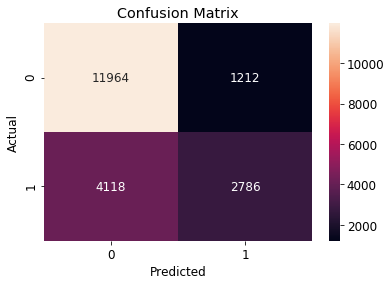

Classification Accuracy: 0.7345617529880478
Classification Error: 0.2654382470119522
False Positive Rate: 0.09198542805100182
Precision: 0.696848424212106
AUC Score: 0.6557743775156347


C:\Users\marc\Anaconda3\envs\hackathon\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\marc\Anaconda3\envs\hackathon\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\marc\Anaconda3\envs\hackathon\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\marc\Anaconda3\envs\hackathon\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\marc\Anaconda3\envs\hackathon\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

Cross-validated AUC: 0.7139180673068772
First 10 predicted responses:
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
First 10 predicted probabilities of class members:
 [[0.84788661 0.15211339]
 [0.33895435 0.66104565]
 [0.80522546 0.19477454]
 [0.74252519 0.25747481]
 [0.62072161 0.37927839]
 [0.6230285  0.3769715 ]
 [0.73835497 0.26164503]
 [0.73746407 0.26253593]
 [0.26332884 0.73667116]
 [0.37538865 0.62461135]]
First 10 predicted probabilities:
 [[0.15211339]
 [0.66104565]
 [0.19477454]
 [0.25747481]
 [0.37927839]
 [0.3769715 ]
 [0.26164503]
 [0.26253593]
 [0.73667116]
 [0.62461135]]


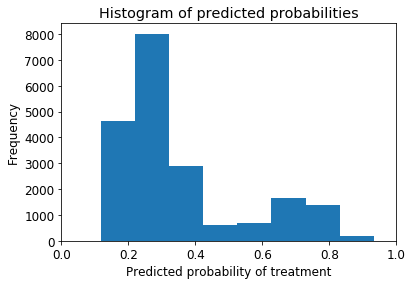

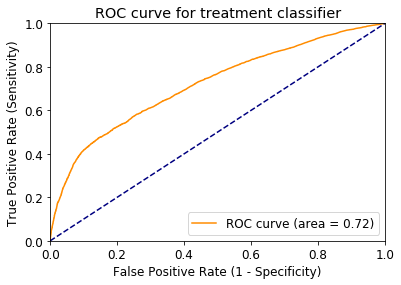

[[11964  1212]
 [ 4118  2786]]


In [57]:
logisticRegression()